In [1]:
import os
import re
import glob
import json
import random
import argparse
import pandas as pd
import numpy as np

import librosa
import soundfile as sf

from tqdm import tqdm
import subprocess
from functools import partial
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import MeCab
import cutlet

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

from transformers import (
    Wav2Vec2Config,
    TFWav2Vec2Model,
    Wav2Vec2CTCTokenizer, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor)

from transformers.modeling_tf_outputs import (
    TFCausalLMOutput
)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Random seed set.")

def ArgParser():
    parser = argparse.ArgumentParser()

    # DataLoader
    parser.add_argument("--main_dir", default="E://Datasets/ASR-dataset")
    parser.add_argument("--sample_rate", default=16000)
    parser.add_argument("--test_size", default=0.2)
    parser.add_argument("--random_state", default=42)
    parser.add_argument("--batch_size", default=4)
    parser.add_argument("--n_shards", default=20)
    parser.add_argument("--buffer_size", default=512)

    # Trainer
    parser.add_argument("--model_name", default="facebook/wav2vec2-base-960h")
    parser.add_argument("--epochs", default=30)
    parser.add_argument("--learning_rate", default=3e-4)
    parser.add_argument("--vocab_size", default=37)

    args = parser.parse_known_args()[0]

    input_shape = (args.max_samples)
    parser.add_argument("--input_shape", default=input_shape)

    seed_everything(args.random_state)
    return parser.parse_known_args()[0]

args = ArgParser()
args

Random seed set.


Namespace(batch_size=4, buffer_size=512, epochs=30, input_shape=150000, learning_rate=0.0003, main_dir='E://Datasets/ASR-dataset', max_labels=150, max_samples=150000, model_name='facebook/wav2vec2-base-960h', n_shards=20, random_state=42, sample_rate=16000, test_size=0.2, vocab_size=37)

# Preprocessing

In [23]:
class Dataset:
    def __init__(self, args):
        self.args = args
        self.data = pd.concat([
            self.get_kokoro(),
            self.get_jsut(),
            self.get_commonvoice()], 
            ignore_index=True)
        self.katsu = cutlet.Cutlet()
        self.wakati = MeCab.Tagger("-Owakati")
        tqdm.pandas()
        self.data['sentence'] = self.data['sentence'].progress_apply(self.clean_kanji)
        self.data['romaji'] = self.data['sentence'].progress_apply(self.katsu.romaji)
        self.data['romaji'] = self.data['romaji'].progress_apply(self.clean_romaji)
        self.data['romaji'] = self.data['romaji'].str.lower()
        self.data['length'] = self.data['path'].progress_apply(self.get_length)
        self.data.query("(length >= 32000) & (length <= 150000)", inplace=True)
        self.data = self.data[self.data['sentence'].apply(list).apply(len)>=5]
        self.data = self.data.dropna().reset_index(drop=True)
        self.data.sort_values(by="length", axis=0, inplace=True, ignore_index=True)
        self.data.to_csv(f"{self.args.main_dir}/ASRDataset.csv", encoding="utf-8", index=False)

    def get_kokoro(self):
        in_dir = "Datasets\Full-KOKORO-dataset"

        data = []
        transcript_path = f"{in_dir}/transcripts/*.metadata.txt"
        for transcript in glob.glob(transcript_path):
            with open(transcript, "r", encoding="utf-8") as f:
                for line in f.readlines():
                    data.append(line.split("|"))

        data = pd.DataFrame(
            data, columns=[
                'text_id', 'path', 'start_idx', 
                'end_idx', 'sentence', 'phonemes'])       

        # paths = data['path'].unique()
        # for path in tqdm(paths, total=len(paths)):
        #     folder_name = path.split("_", 1)[0]
        #     in_path = os.path.join(in_dir, folder_name, path)
        #     y, sr = librosa.load(in_path, sr=None)
        #     for text_id in data.loc[data['path']==path, 'text_id']:
        #         out_path = os.path.join(self.args.main_dir, 'wav_cleaned', text_id) + ".wav"
        #         if not os.path.exists(out_path):
        #             start_idx = int(data.loc[data['text_id']==text_id, 'start_idx'].item())
        #             end_idx = int(data.loc[data['text_id']==text_id, 'end_idx'].item())
        #             y_slice = librosa.resample(
        #                 y[start_idx:end_idx], orig_sr=sr, target_sr=self.args.sample_rate)
        #             sf.write(out_path, y_slice, samplerate=self.args.sample_rate, subtype='PCM_16')

        data = data[['text_id', 'sentence']]
        data['text_id'] = data['text_id'].apply(lambda x: x + ".wav")
        data.columns = ['path', 'sentence']
        data['corpus'] = ['kokoro'] * len(data)
        return data

    def get_jsut(self):
        filenames, sentences = [], []
        for transcript in glob.glob(r"Datasets/JSUT-dataset/*/transcript_utf8.txt"):
            file_path = transcript.rsplit("\\", 1)[0]
            with open(transcript, "r", encoding="utf-8") as f:
                lines = f.readlines()
                for line in lines: 
                    filename, sentence = line.split(":")
                    filenames.append(os.path.join(file_path, "wav", filename) + ".wav")
                    sentences.append(sentence.strip("\n"))
        data = pd.DataFrame({'path': filenames, 'sentence': sentences}) 
        data['corpus'] = ['jsut'] * len(data)
        for i, in_path in tqdm(enumerate(data['path']), total=len(data['path'])):
            in_path = in_path.replace("\\", "/")
            out_path = f"{self.args.main_dir}\wav_cleaned"
            filename = in_path.rsplit("/", 1)[-1]
            out_path = os.path.join(out_path, filename)
            if not os.path.exists(out_path):
                subprocess.call([
                    "ffmpeg", "-i", in_path,"-acodec", "pcm_s16le", 
                    "-ar", str(self.args.sample_rate), out_path])
            data['path'][i] = filename
        return data 

    def get_commonvoice(self):
        data = pd.read_csv(r"Datasets/CommonVoice-dataset/validated.tsv", sep="\t")
        data = data[['path', 'sentence']]    
        data['path'] = data['path'].apply(
            lambda x: r"Datasets/CommonVoice-dataset/mp3/" + x)
        data['corpus'] = ['common_voice'] * len(data)
        for i, in_path in tqdm(enumerate(data['path']), total=len(data['path'])):
            in_path = in_path.replace("\\", "/")
            out_path = f"{self.args.main_dir}\wav_cleaned"
            filename = in_path.rsplit("/", 1)[-1]
            filename = filename.replace("mp3", "wav")
            out_path = os.path.join(out_path, filename)
            if not os.path.exists(out_path):
                subprocess.call([
                    "ffmpeg", "-i", in_path,"-acodec", "pcm_s16le", 
                    "-ar", str(self.args.sample_rate), out_path])
            data['path'][i] = filename       
        return data

    def clean_kanji(self, sentence):
        symbols = r"[（.*?）！-～.,;..._。、-〿・■（）：ㇰ-ㇿ㈠-㉃㊀-㋾㌀-㍿「」『』→ー -~‘–※π—ゐ’“”]"
        sentence = re.sub(symbols, "", sentence)
        sentence = self.wakati.parse(sentence).strip("\n")          
        return sentence

    def clean_romaji(self, sentence):
        return re.sub(r'[.,"\'\/?]', "", sentence)

    def get_length(self, path):
        path = os.path.join(args.main_dir, 'wav_cleaned', path)
        y, sr = librosa.load(path, sr=None)
        return len(y)

data = Dataset(args).data
data

 19%|█▉        | 13734/71975 [00:02<00:11, 4855.34it/s]

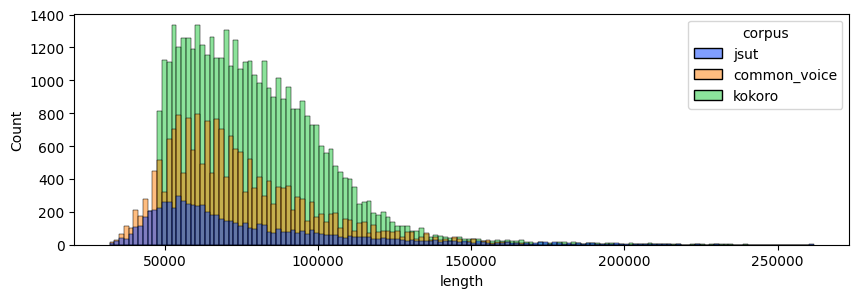

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10, 3))
sns.histplot(x=data['length'], hue=data['corpus'], ax=ax, palette="bright")
plt.show()

# Data Loading

In [5]:
class Config:
    def __init__(self, args):
        self.tokenizer = Wav2Vec2CTCTokenizer(
            f"{args.main_dir}/vocab.json",
            word_delimiter_token=' ',
            do_lower_case=False)

        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
            args.model_name)

        self.processor = Wav2Vec2Processor(
            feature_extractor=self.feature_extractor, 
            tokenizer=self.tokenizer)

In [6]:
class TFRWriter():
    def __init__(self, args):
        self.data = pd.read_csv(os.path.join(args.main_dir, "ASRDataset.csv"))
        self.args = args
        self.processor = Config(args).processor

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'input_values': self._bytes_feature(args[0]),
            'input_length': self._int64_feature(args[1]),
            'label_ids': self._bytes_feature(args[2]),
            'label_length': self._int64_feature(args[3])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_labels(self, sample):
        labels = self.data.loc[self.data['path']==sample, "romaji"].item()
        labels = (self.processor.tokenizer.bos_token + labels + 
            self.processor.tokenizer.eos_token)
        labels = self.processor.tokenizer(
            labels)['input_ids'][:self.args.max_labels]
        label_length = len(labels)
        return (
            tf.convert_to_tensor(labels, dtype=tf.int32),
            tf.convert_to_tensor(label_length, dtype=tf.int32)
        )

    def get_audio(self, sample):
        path = os.path.join(self.args.main_dir, "wav_cleaned", sample)
        audio = librosa.load(path, sr=None)[0]
        return tf.convert_to_tensor(audio, dtype=tf.float32)

    def get_shards(self):
        skf = KFold(n_splits=self.args.n_shards, shuffle=False)
        return [
            list(map(lambda x: self.data['path'][x], j))
            for i, j in skf.split(self.data['path'])
        ]

    def get_shard_data(self, samples):
        longest_length = self.data.loc[self.data['path'].isin(samples), 'length'].max()
        for sample in samples:
            audio = self.get_audio(sample)
            labels, label_length = self.get_labels(sample)
            audio_length = self.data.loc[self.data['path']==sample, "length"].item()
            yield {
                'input_values': tf.io.serialize_tensor(audio),
                'input_length': audio_length,
                'label_ids': tf.io.serialize_tensor(labels),
                'label_length': label_length
            }

    def write(self):
        for shard, samples in tqdm(enumerate(self.get_shards()), total=self.args.n_shards):
            with tf.io.TFRecordWriter(f"{self.args.main_dir}/tfrec_data/shard_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples):
                    example = self.serialize_example(
                        sample['input_values'], sample['input_length'],
                        sample['label_ids'], sample['label_length'])
                    f.write(example)

# TFRWriter(args).write()

100%|██████████| 20/20 [20:50<00:00, 62.53s/it]


In [7]:
class DataLoader:
    def __init__(self, args):
        self.files = glob.glob(args.main_dir + "/tfrec_data/*.tfrec")
        self.args = args
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=args.test_size, shuffle=True, 
            random_state=args.random_state)
        self.train = self.train()
        self.val = self.val()
   
    def read_tfrecord(self, example):
        feature_description = {
            'input_values': tf.io.FixedLenFeature([], tf.string),
            'input_length': tf.io.FixedLenFeature([], tf.int64),
            'label_ids': tf.io.FixedLenFeature([], tf.string),
            'label_length': tf.io.FixedLenFeature([], tf.int64)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['input_values'] = tf.io.parse_tensor(
            example['input_values'], out_type=tf.float32)
        example['label_ids'] = tf.io.parse_tensor(
            example['label_ids'], out_type=tf.int32)
        example['input_length'] = tf.cast(example['input_length'], dtype=tf.int32)
        example['label_length'] = tf.cast(example['label_length'], dtype=tf.int32)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset
    
    def split(self, dataset):
        return (
            {
                "input_values": dataset["input_values"],
                "input_length": dataset["input_length"] 
            },
            {
                "label_ids": dataset["label_ids"],
                "label_length": dataset["label_length"]
            }
        )

    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_values': [None],
                'input_length': [],
                'label_ids': [None],
                'label_length': []},
            padding_values={
                'input_values': tf.constant(0, dtype=tf.float32), 
                'input_length': None,
                'label_ids': tf.constant(-100, dtype=tf.int32),
                'label_length': None})
        dataset = dataset.map(self.split, num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_values': [None],
                'input_length': [],
                'label_ids': [None],
                'label_length': []},
            padding_values={
                'input_values': tf.constant(0, dtype=tf.float32), 
                'input_length': None,
                'label_ids': tf.constant(-100, dtype=tf.int32),
                'label_length': None})
        dataset = dataset.map(self.split, num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

({'input_values': <tf.Tensor: shape=(4, 98267), dtype=float32, numpy=
array([[ 3.0517578e-05, -6.1035156e-05, -1.8310547e-04, ...,
         3.0517578e-05,  0.0000000e+00,  0.0000000e+00],
       [-6.1035156e-05, -1.5258789e-04, -2.1362305e-04, ...,
         6.1035156e-05,  3.0517578e-05,  0.0000000e+00],
       [-6.1035156e-05,  0.0000000e+00,  6.1035156e-05, ...,
         6.1035156e-05,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  3.0517578e-05,  3.0517578e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)>, 'input_length': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([98267, 98267, 98267, 98267])>}, {'label_ids': <tf.Tensor: shape=(4, 103), dtype=int32, numpy=
array([[   1,   12,    6,   11,    7,    6,    4,   19,    5,    4,   15,
           6,   13,   10,    4,   19,    6,    4,   22,    7,   11,    7,
          17,    5,   16,    7,   12,    5,    4,    6,    9,    9,    5,
           4,    9,    6,    4,    9,    5,   23,    8,   

# Model Training

In [10]:
class TFWav2Vec2ForCTC(tf.keras.Model):
    def __init__(self, args):
        super(TFWav2Vec2ForCTC, self).__init__()
        self.args = args
        self.config = Wav2Vec2Config.from_pretrained(
            args.model_name, vocab_size=args.vocab_size,
            output_hidden_states=True)
        self.base_layer = TFWav2Vec2Model.from_pretrained(
            args.model_name, config=self.config, name="wav2vec2")
        self.dropout = tf.keras.layers.Dropout(0.1, name="dropout")
        self.lm_head = tf.keras.layers.Dense(
            args.vocab_size, activation="softmax", name="lm_head")

    def call(self, inputs, labels, training):
        outputs = self.base_layer(input_values=inputs['input_values'])
        x = outputs.last_hidden_state
        x = self.dropout(x, training)
        logits = self.lm_head(x)
        
        if labels is not None:
            if tf.reduce_max(labels['label_ids']) >= self.config.vocab_size:
                raise ValueError(f"Label values must be <= vocab_size: {self.config.vocab_size}")
    
            loss = tf.nn.ctc_loss(
                logits=logits,
                labels=labels['label_ids'],
                logit_length=inputs['input_length'],
                label_length=labels['label_length'],
                blank_index=self.config.pad_token_id,
                logits_time_major=False
            )
            
            if self.config.ctc_loss_reduction == "sum":
                loss = tf.reduce_sum(loss)
            elif self.config.ctc_loss_reduction == "mean":
                loss = tf.reduce_mean(loss)
            else:
                raise ValueError(f"ctc_loss_reduction must be either sum or mean.")
        else:
            loss = None
                        
        return TFCausalLMOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions)

    def serving_output(self, output: TFCausalLMOutput) -> TFCausalLMOutput:
        if self.config.output_hidden_states:
            hs = tf.convert_to_tensor(output.hidden_states)
        else:
            hs = None
        if self.config.output_attentions:
            attns = tf.convert_to_tensor(output.attentions)
        else:
            attns = None
        
        return TFCausalLMOutput(
            logits=output.logits, hidden_states=hs, attentions=attns)

Some layers from the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing TFWav2Vec2Model: ['dropout_50', 'lm_head']
- This IS expected if you are initializing TFWav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFWav2Vec2Model were initialized from the model checkpoint at facebook/wav2vec2-base-960h.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWav2Vec2Model for predictions without further training.


TFCausalLMOutput(loss=<tf.Tensor: shape=(), dtype=float32, numpy=3327.6733>, logits=<tf.Tensor: shape=(4, 300, 37), dtype=float32, numpy=
array([[[0.02022143, 0.03404899, 0.03513526, ..., 0.04620755,
         0.04047517, 0.01683033],
        [0.02023644, 0.03418202, 0.03534433, ..., 0.04626592,
         0.04071999, 0.01663663],
        [0.02049548, 0.0344748 , 0.0350819 , ..., 0.04604213,
         0.04065494, 0.01681461],
        ...,
        [0.02002366, 0.03326676, 0.03247846, ..., 0.04860095,
         0.03537069, 0.01772717],
        [0.02026852, 0.03218693, 0.0346241 , ..., 0.04436938,
         0.04196112, 0.01634735],
        [0.02034456, 0.03194546, 0.03485507, ..., 0.04412682,
         0.04173673, 0.01638306]],

       [[0.02305269, 0.03395809, 0.03489815, ..., 0.04970449,
         0.03807245, 0.0180183 ],
        [0.023111  , 0.03414403, 0.03468358, ..., 0.04959102,
         0.03777518, 0.01819889],
        [0.02311776, 0.03380324, 0.0348853 , ..., 0.0496993 ,
         0.038315

In [12]:
class Trainer:
    def __init__(self, args):
        self.args = args
        self.model = TFWav2Vec2ForCTC(args)
        self.dataloader = DataLoader(args)
    
    def fit(self):
        for epoch in range(self.args.epochs):
            print(f"Epoch {epoch+1}/{self.args.epochs}")
            for step, (X_train, y_train) in enumerate(self.dataloader.train):
                with tf.GradientTape() as tape:
                    t_logits = self.model(X_train, y_train, training=True)
                    # t_loss = self.loss_fn(y_train, t_logits)
                    print(t_logits)
                # grads = 

Trainer(args).fit()

Some layers from the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing TFWav2Vec2Model: ['dropout_50', 'lm_head']
- This IS expected if you are initializing TFWav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFWav2Vec2Model were initialized from the model checkpoint at facebook/wav2vec2-base-960h.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWav2Vec2Model for predictions without further training.


Epoch 0/30


ResourceExhaustedError: failed to allocate memory [Op:Erf]